In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import ipywidgets as widgets
import itertools
import tqdm
import os
import glob
import sys

utils_path = os.path.abspath(r"C:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis")
if utils_path not in sys.path:
    sys.path.append(utils_path)
from utils.utils import *
from utils.image import Image
from utils.Visualizations import create_subplot


## Defining the images and iteration values:

In [2]:
dotmark_pictures_path = "..\\..\\DOTmark_1.0\\Pictures\\"
full_path = os.path.join(os.getcwd(), dotmark_pictures_path)
resolution = 32
image_numbers = ['01','02','03','04','05','06','07','08','09','10']
category_dirs = [path for path in glob.glob(os.path.join(dotmark_pictures_path, "*")) if os.path.isdir(path)]
category_names = [os.path.basename(category) for category in category_dirs if os.path.isdir(category)]

SNR_values = np.logspace(start=5, stop=1, num=31)
noise_values = np.logspace(start=-5, stop=-1, num=31)
pairs = list(itertools.combinations(image_numbers, 2))
cost_matrix = calculate_costs((resolution, resolution), distance_metric='L1')
df_im_l1 = pd.DataFrame()

### Look into a single pair of images:

In [ ]:
image1 = Image(full_path, category_names[0], image_numbers[0], resolution)
image2 = Image(full_path, category_names[0], image_numbers[1], resolution)
noise_param = 1e-2

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
create_subplot(axs[0], image1.image, "Image 1")
create_subplot(axs[1], image2.image, "Image 2")

In [ ]:
results = Image.analyze_image_pair(image1, image2, cost_matrix, 1, noise_param)
#plot:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
create_subplot(axs[0], image1.image_post, "Image 1")
create_subplot(axs[1], image2.image_post, "Image 2")

In [ ]:
w1_dist_original = calculate_and_time_wasserstein(image1.image, image2.image, cost_matrix)[0]
w1_dist_noised = calculate_and_time_wasserstein(image1.image_post, image2.image_post, cost_matrix)[0]
print(f'The Wasserstein distance between the two original images is {w1_dist_original}, and between the two noised images is {w1_dist_noised}')

f_dist_original = calculate_and_time_fourier1(image1.image, image2.image)[0]
f_dist_noised = calculate_and_time_fourier1(image1.image_post, image2.image_post)[0]
print(f'The Fourier distance between the two original images is {f_dist_original}, and between the two noised images is {f_dist_noised}')

l2_dist_original = calculate_and_time_l2(image1.image, image2.image)[0]
image1.image_noised /= image1.image_noised.sum()
image2.image_noised /= image2.image_noised.sum()
l2_dist_noised = calculate_and_time_l2(image1.image_noised, image2.image_noised)[0]
print(f'The L2 distance between the two original images is {l2_dist_original}, and between the two noised images is {l2_dist_noised}')


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
create_subplot(axs[0], image1.image_post, "Image 1")
create_subplot(axs[1], image2.image_post, "Image 2")

### Create the data from scratch - single class

In [ ]:
category = category_names[0]
num_samples = 5

for SNR in tqdm(SNR_values):
    noise_param = noise_from_SNR(SNR, 1, resolution)
    for image_pair in pairs:
        image1 = Image(resolution, category, image_pair[0], full_path)
        image2 = Image(resolution, category, image_pair[1], full_path)

        # Calculate original distances without noise
        w1_dist_original, w1_time_original = calculate_and_time_wasserstein(image1.image, image2.image, cost_matrix)
        f_dist_original, f_time_original = calculate_and_time_fourier1(image1.image, image2.image)
        l2_dist_original, l2_time_original = calculate_and_time_l2(image1.image, image2.image)

        results = Image.analyze_image_pair(image1, image2, cost_matrix, num_samples, noise_param)
        w1_dist_noised, f_dist_noised, l2_dist_noised, time_w1, time_f, time_l2 = results

        new_row = {
            'Category': category,
            'image1_index': image_pair[0],
            'image2_index': image_pair[1],
            'Noise': noise_param,
            'SNR': SNR,
            'Resolution': resolution,
            'Wasserstein Original': w1_dist_original,
            'Wasserstein Noised': w1_dist_noised,
            'Wasserstein Ratio': w1_dist_original / w1_dist_noised,
            'Wasserstein Time': time_w1,
            'Fourier Original': f_dist_original, 
            'Fourier Noised': f_dist_noised,
            'Fourier Ratio': f_dist_original / f_dist_noised,
            'Fourier Time': time_f, 
            'L2 Original': l2_dist_original,
            'L2 Noised': l2_dist_noised,
            'L2 Ratio': l2_dist_original / l2_dist_noised,
            'L2 Time': time_l2}  
        
        df_im_l1 = df_im_l1._append(new_row, ignore_index=True)
df_im_l1.to_csv('csvs/L2_F_noised_W1_post_24_4_2024.csv', index=False)


In [ ]:
df_im_l1 = pd.read_csv('csvs/L2_F_noised_W1_post_2_4_2024.csv')

In [ ]:
subset = df_im_l1.drop(['Category','image1_index', 'image2_index'], axis=1)
df_grouped = subset.groupby('SNR').mean().reset_index()
df_grouped.head()

In [ ]:
plt.plot(1/df_grouped['SNR'], 1 / df_grouped['Wasserstein Ratio'], label=f'Ratio EMD, category={category}', color='blue')
plt.plot(1/df_grouped['SNR'], df_grouped['L2 Ratio'], label='Ratio Linear', color='black', linestyle='--')
plt.plot(1/df_grouped['SNR'], df_grouped['Fourier Ratio'], label='Ratio Fourier', color='red', linestyle='--')

plt.xscale('log')
plt.title(f'Ratio of original to noised distance, category={category}')
plt.xlabel('1/SNR')
plt.ylabel('Ratio')
plt.legend()

plt.show()

### Create the data from scratch - All classes:

In [50]:
image_pair

('01', '09')

In [51]:
w_normal = calculate_and_time_wasserstein(image1.image, image2.image, cost_matrix)
print(f'The Wasserstein distance between the two original images is {w_normal[0]}')

The Wasserstein distance between the two original images is 4.530320813389161


In [76]:
uot = calculate_and_time_UOT(image1.image, image2.image, cost_matrix, 5e-4, 5e-10)
print(f'The UOT distance between the two original images is {np.sum(uot[0])}')

The UOT distance between the two original images is 0.0009765625


In [71]:
xs = image1.image_post.flatten()
xt = image2.image_post.flatten()

In [55]:
xs.shape

(1024,)

1e-05

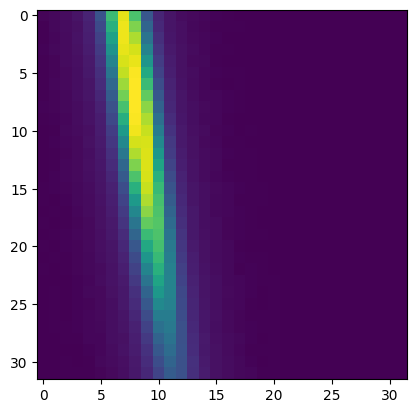

In [63]:
plt.imshow(image1.image_post)
noise_param

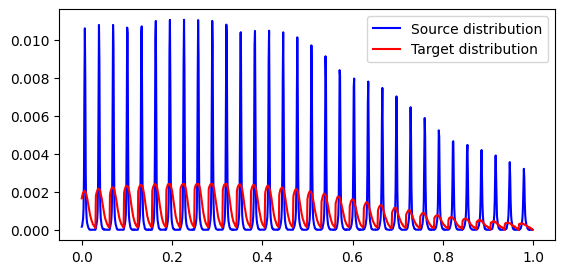

In [61]:
x = np.arange(0, 1, 1/1024)
plt.figure(1, figsize=(6.4, 3))
plt.plot(x, xs, 'b', label='Source distribution')
plt.plot(x, xt, 'r', label='Target distribution')
plt.legend()

In [57]:
reg = 5e-7
reg_m_kl = 0.05
reg_m_l2 = 5
mass = 0.9

# Compute the transport plans
entropic_kl_uot = ot.unbalanced.sinkhorn_unbalanced(xs, xt, cost_matrix, reg, reg_m_kl)
kl_uot = ot.unbalanced.mm_unbalanced(xs, xt, cost_matrix, reg_m_kl, div='kl')
l2_uot = ot.unbalanced.mm_unbalanced(xs, xt, cost_matrix, reg_m_l2, div='l2')
partial_ot = ot.partial.partial_wasserstein(xs, xt, cost_matrix, m=mass)
ot_plan = ot.emd(xs, xt, cost_matrix)

c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:405: RuntimeWarning: divide by zero encountered in divide
  v = (b / Ktu) ** fi
c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:412: UserWarning: Numerical errors at iteration 0
  warnings.warn('Numerical errors at iteration %s' % i)


In [59]:
# Calculate the cost 
entropic_kl_cost = np.sum(entropic_kl_uot * cost_matrix)
kl_cost = np.sum(kl_uot * cost_matrix)
l2_cost = np.sum(l2_uot * cost_matrix)
partial_ot_cost = np.sum(partial_ot * cost_matrix)
ot_cost = np.sum(ot_plan * cost_matrix)

print(f'The cost of the entropic KL UOT is {entropic_kl_cost}')
print(f'The cost of the KL UOT is {kl_cost}')
print(f'The cost of the L2 UOT is {l2_cost}')
print(f'The cost of the partial OT is {partial_ot_cost}')
print(f'The cost of the OT is {ot_cost}')

The cost of the entropic KL UOT is 0.0
The cost of the KL UOT is 7.803224805220206e-10
The cost of the L2 UOT is 0.0
The cost of the partial OT is 2.771202177011984
The cost of the OT is 4.518096284725049


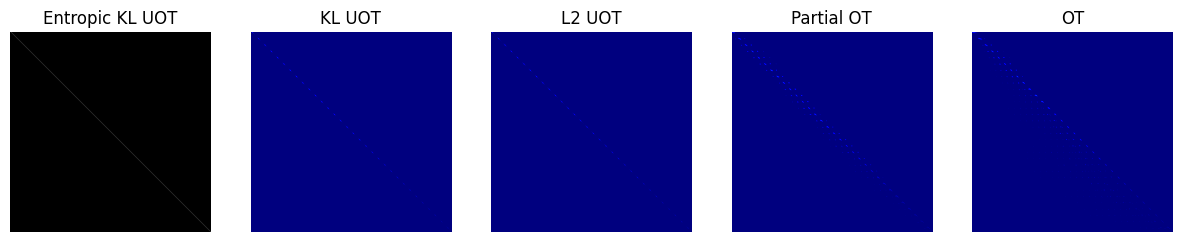

In [64]:
plt.figure(figsize=(15, 5))
# Plot 4 plots, one for each uot
plt.subplot(1, 5, 1)
plt.imshow(entropic_kl_uot, cmap='gray')
plt.title('Entropic KL UOT')
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(kl_uot, cmap='jet')
plt.title('KL UOT')
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(l2_uot, cmap='jet')
plt.title('L2 UOT')
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(partial_ot, cmap='jet')
plt.title('Partial OT')
plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(ot_plan, cmap='jet')
plt.title('OT')
plt.axis('off')

plt.show()

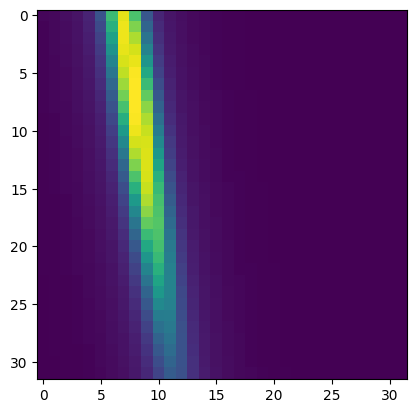

In [16]:
plt.imshow(image1.image)

In [3]:
df_im_l1 = pd.DataFrame()
num_samples = 10
for category in category_names:
    for noise_param in tqdm.tqdm(noise_values):
        SNR = 1 / noise_param
        for image_pair in pairs:
            image1 = Image(resolution, category, image_pair[0], full_path)
            image2 = Image(resolution, category, image_pair[1], full_path)

            original_results = Image.calculate_distances(image1, image2, cost_matrix)
            results = Image.analyze_image_pair(image1, image2, cost_matrix, num_samples, noise_param)


            print(f'Unbalanced distance between the two original images is \
                  {original_results["u"]["distance"]}, and between the two noised images is {results["u"]["distance"]}')
            new_row = {
                'Category': category,
                'image1_index': image_pair[0],
                'image2_index': image_pair[1],
                'Noise': noise_param,
                'SNR': SNR,
                'Resolution': resolution,
                
                'Wasserstein Original': original_results["w1"]["distance"],
                'Wasserstein Noised': results["w1"]["distance"],
                'Wasserstein Ratio': original_results["w1"]["distance"] / results["w1"]["distance"],
                'Wasserstein Time': results["w1"]["time"],

                'Fourier Original': original_results["f"]["distance"], 
                'Fourier Noised': results["f"]["distance"],
                'Fourier Ratio': original_results["f"]["distance"] / results["f"]["distance"],
                'Fourier Time': results["f"]["time"],

                'L2 Original': original_results["l2"]["distance"],
                'L2 Noised': results["l2"]["distance"],
                'L2 Ratio': original_results["l2"]["distance"] / results["l2"]["distance"],
                'L2 Time': results["l2"]["time"],

                'UOT Original': original_results["u"]["distance"],
                'UOT Noised': results["u"]["distance"],
                'UOT Ratio': original_results["u"]["distance"] / results["u"]["distance"],
                'UOT Time': results["u"]["time"]
                }
            df_im_l1 = df_im_l1._append(new_row, ignore_index=True)
df_im_l1.to_csv('../csvs/results_uot_images_11_6_2024.csv', index=False)


  0%|          | 0/31 [00:00<?, ?it/s]c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:405: RuntimeWarning: divide by zero encountered in divide
  v = (b / Ktu) ** fi
c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:405: RuntimeWarning: invalid value encountered in divide
  v = (b / Ktu) ** fi
c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:412: UserWarning: Numerical errors at iteration 0
  warnings.warn('Numerical errors at iteration %s' % i)


Unbalanced distance between the two original images is                   [[9.53674316e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.53674316e-07 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.53674316e-07 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.53674316e-07
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  9.53674316e-07 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.53674316e-07]], and between the two noised images is 9.313225746154785e-10


c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:405: RuntimeWarning: divide by zero encountered in divide
  v = (b / Ktu) ** fi
c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:405: RuntimeWarning: invalid value encountered in divide
  v = (b / Ktu) ** fi
c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:412: UserWarning: Numerical errors at iteration 0
  warnings.warn('Numerical errors at iteration %s' % i)


Unbalanced distance between the two original images is                   [[9.53674316e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.53674316e-07 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.53674316e-07 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.53674316e-07
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  9.53674316e-07 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.53674316e-07]], and between the two noised images is 9.313225746154785e-10


c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:405: RuntimeWarning: divide by zero encountered in divide
  v = (b / Ktu) ** fi
c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:405: RuntimeWarning: invalid value encountered in divide
  v = (b / Ktu) ** fi
c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:412: UserWarning: Numerical errors at iteration 0
  warnings.warn('Numerical errors at iteration %s' % i)


Unbalanced distance between the two original images is                   [[9.53674316e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.53674316e-07 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.53674316e-07 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.53674316e-07
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  9.53674316e-07 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.53674316e-07]], and between the two noised images is 9.313225746154785e-10


c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:405: RuntimeWarning: divide by zero encountered in divide
  v = (b / Ktu) ** fi
c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:405: RuntimeWarning: invalid value encountered in divide
  v = (b / Ktu) ** fi
c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:412: UserWarning: Numerical errors at iteration 0
  warnings.warn('Numerical errors at iteration %s' % i)


Unbalanced distance between the two original images is                   [[9.53674316e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.53674316e-07 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.53674316e-07 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.53674316e-07
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  9.53674316e-07 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.53674316e-07]], and between the two noised images is 9.313225746154785e-10


c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:405: RuntimeWarning: divide by zero encountered in divide
  v = (b / Ktu) ** fi
c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:412: UserWarning: Numerical errors at iteration 0
  warnings.warn('Numerical errors at iteration %s' % i)


Unbalanced distance between the two original images is                   [[9.53674316e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.53674316e-07 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.53674316e-07 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.53674316e-07
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  9.53674316e-07 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.53674316e-07]], and between the two noised images is 9.313225746154785e-10


c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:405: RuntimeWarning: divide by zero encountered in divide
  v = (b / Ktu) ** fi
c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:405: RuntimeWarning: invalid value encountered in divide
  v = (b / Ktu) ** fi
c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:412: UserWarning: Numerical errors at iteration 0
  warnings.warn('Numerical errors at iteration %s' % i)


Unbalanced distance between the two original images is                   [[9.53674316e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.53674316e-07 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.53674316e-07 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.53674316e-07
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  9.53674316e-07 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.53674316e-07]], and between the two noised images is 9.313225746154785e-10


c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:405: RuntimeWarning: divide by zero encountered in divide
  v = (b / Ktu) ** fi
c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:405: RuntimeWarning: invalid value encountered in divide
  v = (b / Ktu) ** fi
c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:412: UserWarning: Numerical errors at iteration 0
  warnings.warn('Numerical errors at iteration %s' % i)
c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:405: RuntimeWarning: divide by zero encountered in divide
  v = (b / Ktu) ** fi
c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\unbalanced.py:405: RuntimeWarning: invalid value encountered in divide
  v = (b / Ktu) ** fi
c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages

Unbalanced distance between the two original images is                   [[9.53674316e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.53674316e-07 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.53674316e-07 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.53674316e-07
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  9.53674316e-07 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.53674316e-07]], and between the two noised images is 9.313225746154785e-10


KeyboardInterrupt: 

In [11]:
df_im_l1 = pd.read_csv('../csvs/L2_F_noised_W1_post_2_4_2024.csv')

In [12]:
category_index = 8
subset = df_im_l1[df_im_l1['Category'] == category_names[category_index]]
subset = df_im_l1.drop(['Category','image1_index', 'image2_index'], axis=1)
df_grouped = subset.groupby('Noise').mean().reset_index()

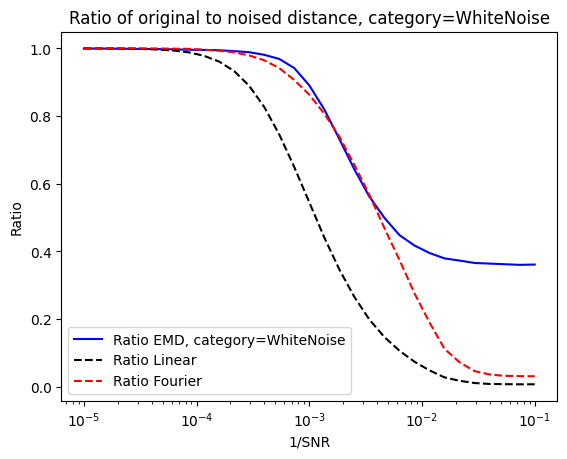

In [16]:
plt.plot(1/df_grouped['SNR'], 1 / df_grouped['Wasserstein Ratio'], 
         label=f'Ratio EMD, category={category_names[category_index]}', color='blue')
plt.plot(1/df_grouped['SNR'], df_grouped['L2 Ratio'], label='Ratio Linear', color='black', linestyle='--')
plt.plot(1/df_grouped['SNR'], df_grouped['Fourier Ratio'], label='Ratio Fourier', color='red', linestyle='--')

plt.xscale('log')
plt.title(f'Ratio of original to noised distance, category={category}')
plt.xlabel('1/SNR')
plt.ylabel('Ratio')
plt.legend()

plt.show()

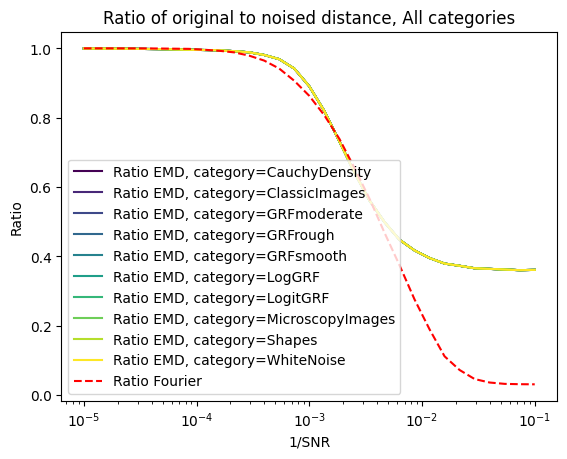

In [14]:
colors = plt.cm.viridis(np.linspace(0, 1, 10))
for category in category_names:
    category_index = category_names.index(category)
    subset = df_im_l1[df_im_l1['Category'] == category]
    subset = df_im_l1.drop(['Category','image1_index', 'image2_index'], axis=1)
    df_grouped = subset.groupby('Noise').mean().reset_index()

    plt.plot(1/df_grouped['SNR'], 1 / df_grouped['Wasserstein Ratio'], label=f'Ratio EMD, category={category}', color=colors[category_index])
plt.plot(1/df_grouped['SNR'], df_grouped['Fourier Ratio'], label='Ratio Fourier', color='red', linestyle='--')

plt.xscale('log')
plt.title(f'Ratio of original to noised distance, All categories')
plt.xlabel('1/SNR')
plt.ylabel('Ratio')
plt.legend()

plt.show()

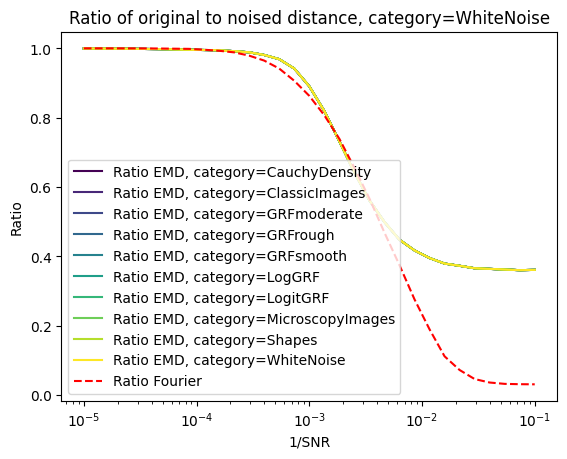

In [15]:
colors = plt.cm.viridis(np.linspace(0, 1, 10))
for category in category_names:
    category_index = category_names.index(category)
    subset = df_im_l1[df_im_l1['Category'] == category]
    subset = df_im_l1.drop(['Category','image1_index', 'image2_index'], axis=1)
    df_grouped = subset.groupby('Noise').mean().reset_index()

    plt.plot(1/df_grouped['SNR'], 1 / df_grouped['Wasserstein Ratio'], label=f'Ratio EMD, category={category}', color=colors[category_index])
plt.plot(1/df_grouped['SNR'], df_grouped['Fourier Ratio'], label='Ratio Fourier', color='red', linestyle='--')

plt.xscale('log')
plt.title(f'Ratio of original to noised distance, category={category}')
plt.xlabel('1/SNR')
plt.ylabel('Ratio')
plt.legend()

plt.show()

In [3]:
im_size_values = [int(x) for x in np.linspace(start=10, stop=50, num=5)]
SNR_values = np.logspace(start=3, stop=-2, num=31)

In [4]:
im_size_values

[10, 20, 30, 40, 50]

In [5]:
im_size = 50
SNR = SNR_values[0]
im1 = np.zeros((im_size, im_size))
im1[int(0.1 * im_size): int(0.3 * im_size), int(0.1 * im_size): int(0.3 * im_size)] = 1  # defining what the value in each of the non-zero pixels will be
im2 = np.zeros((im_size, im_size))
im2[int(0.7 * im_size): int(0.9 * im_size), int(0.7 * im_size): int(0.9 * im_size)] = 1 # defining what the value in each of the non-zero pixels will be

(-0.5, 49.5, 49.5, -0.5)

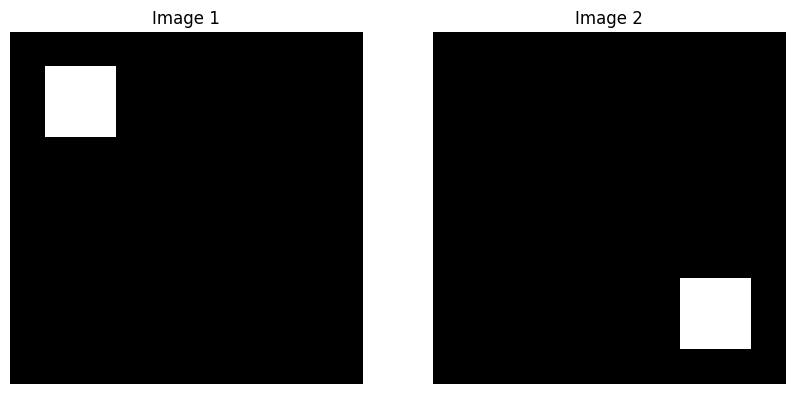

In [7]:
# Create a figure to hold the subplots
plt.figure(figsize=(10, 5))

# Display im1
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(im1, cmap='gray')
plt.title('Image 1')
plt.axis('off')  # Hide the axis

# Display im2
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(im2, cmap='gray')
plt.title('Image 2')
plt.axis('off')  # Hide the axis

#plt.savefig('images/images.png')

## Make sure that the different metrics are indeed different

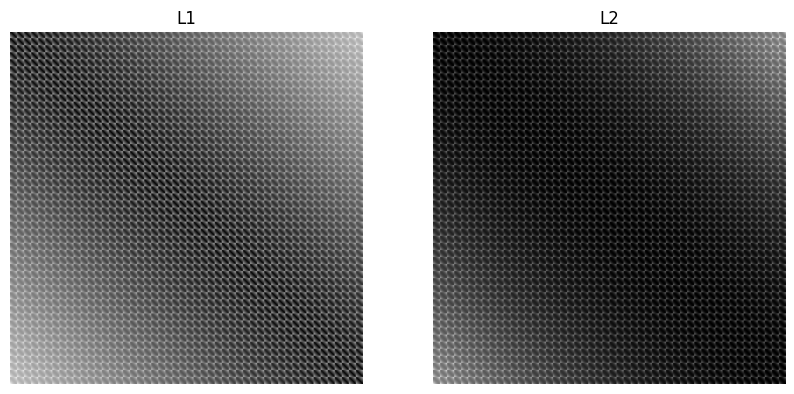

In [8]:
cost_matrix_l1 = calculate_costs(im1.shape, 'L1')
cost_matrix_l2 = calculate_costs(im1.shape, 'L2')
# Create a figure to hold the subplots
plt.figure(figsize=(10, 5))

# Display im1
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
cost_matrix_l1 = calculate_costs(im1.shape, 'L1')
plt.imshow(cost_matrix_l1, cmap='gray')
plt.title('L1')
plt.axis('off')  # Hide the axis

# Display im2
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
cost_matrix_l2 = calculate_costs(im1.shape, 'L2')
plt.imshow(cost_matrix_l2, cmap='gray')
plt.title('L2')
plt.axis('off')  # Hide the axis

plt.show()

[3 4 4 ... 4 4 3]


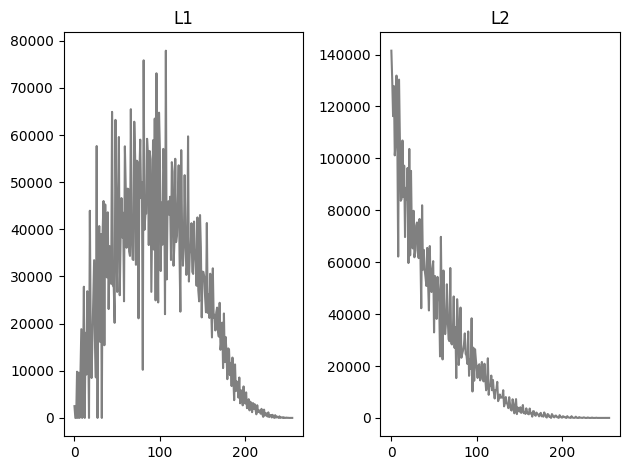

In [9]:
print(sum(cost_matrix_l1 == cost_matrix_l2))
cost_matrix_l1.shape

# Calculate the histogram
hist_l1, bins_im1 = np.histogram(cost_matrix_l1.flatten(), bins=256, range=[np.min(cost_matrix_l1), np.max(cost_matrix_l1)])
hist_l2, bins_im2 = np.histogram(cost_matrix_l2.flatten(), bins=256, range=[np.min(cost_matrix_l2), np.max(cost_matrix_l2)])

# Display im1
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(hist_l1, color='gray')
plt.title('L1')
# plt.axis('off')  # Hide the axis

# Display im2
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(hist_l2, color='gray')
plt.title('L2')


plt.tight_layout()
plt.show()

## L1 distance matrix

### If I want to read existing results:

In [11]:
df_im_l1 = pd.read_csv('../csvs/images_l1_metric.csv')
save_value = False

### If I want to calculate new results:

In [ ]:
df_im_l1 = pd.DataFrame()

for im_size in tqdm.tqdm(im_size_values):
    for SNR in SNR_values:
        im1 = np.zeros((im_size, im_size))
        im1[int(0.1 * im_size): int(0.3 * im_size), int(0.1 * im_size): int(0.3 * im_size)] = 1  # defining what the value in each of the non-zero pixels will be
        im2 = np.zeros((im_size, im_size))
        im2[int(0.7 * im_size): int(0.9 * im_size), int(0.7 * im_size): int(0.9 * im_size)] = 1 # defining what the value in each of the non-zero pixels will be
        
        df_im_l1 = run_experiment_and_append_images(df=df_im_l1, im1=im1, im2=im2, SNR=SNR, distance_metric='L2', n_samples=30)

#### If I want to save:

In [56]:
#save_value = True
if save_value:
    df_im_l1.to_csv('csvs/images_l1_metric.csv', index=False)

### Plotting:

In [17]:
print(len(df_im_l1['Im_Size'].unique()))
print(len(df_im_l1['SNR'].unique()))
print(len(df_im_l1.index))

5
31
155


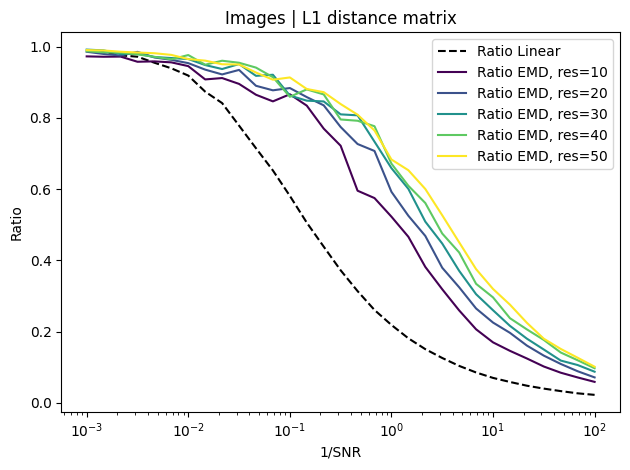

In [18]:
subset = df_im_l1[df_im_l1['Im_Size'] == im_size_values[1]]
plt.plot(1/subset['SNR'], subset['Ratios_Linear'], label='Ratio Linear', color='black', linestyle='--')

colors = plt.cm.viridis(np.linspace(0, 1, len(im_size_values)))  # Generate colors for each 'res' value

for i, res_option in enumerate(im_size_values):
    # Filter the dataframe based on current 'res' option
    filtered_df = df_im_l1[df_im_l1['Im_Size'] == res_option]
    plt.plot(1/filtered_df['SNR'], filtered_df['Ratios_EMD'], label=f'Ratio EMD, res={res_option}', color=colors[i])

plt.xscale('log')
plt.title('Images | L1 distance matrix')
plt.xlabel('1/SNR')
plt.ylabel('Ratio')
plt.legend()

plt.tight_layout()
plt.show()
#plt.savefig('images/comparison/images_l1')

In [19]:
#SNR Values
print(df_im_l1['SNR'].unique())

[1.00000000e+03 6.81292069e+02 4.64158883e+02 3.16227766e+02
 2.15443469e+02 1.46779927e+02 1.00000000e+02 6.81292069e+01
 4.64158883e+01 3.16227766e+01 2.15443469e+01 1.46779927e+01
 1.00000000e+01 6.81292069e+00 4.64158883e+00 3.16227766e+00
 2.15443469e+00 1.46779927e+00 1.00000000e+00 6.81292069e-01
 4.64158883e-01 3.16227766e-01 2.15443469e-01 1.46779927e-01
 1.00000000e-01 6.81292069e-02 4.64158883e-02 3.16227766e-02
 2.15443469e-02 1.46779927e-02 1.00000000e-02]


In [22]:
df_im_l1.head()

,SNR,Noise_Param,Im_Size,Distances_Classic,Distances_Noised,CI_Distances_Noised,Ratios_EMD,Distances_Linear,Distances_Linear_Noised,CI_Distances_Linear_Noised,Ratios_Linear
0,1000.000000,0.020000,10.0,33.941125,34.911830,0.267889,0.972554,2.828427,2.850778,0.011986,0.992270
1,681.292069,0.024231,10.0,33.941125,34.953592,0.328701,0.971565,2.828427,2.856430,0.012756,0.990320
2,464.158883,0.029356,10.0,33.941125,34.937875,0.325647,0.971997,2.828427,2.861060,0.014165,0.988746
3,316.227766,0.035566,10.0,33.941125,35.487502,0.465505,0.957480,2.828427,2.889350,0.014482,0.979069
4,215.443469,0.043089,10.0,33.941125,35.475007,0.600962,0.958529,2.828427,2.875546,0.023098,0.984010


In [27]:
new_subset = df_im_l1[(df_im_l1['Im_Size'] == 30)]

In [28]:
new_subset.head()

,SNR,Noise_Param,Im_Size,Distances_Classic,Distances_Noised,CI_Distances_Noised,Ratios_EMD,Distances_Linear,Distances_Linear_Noised,CI_Distances_Linear_Noised,Ratios_Linear
62,1000.000000,0.034641,30.0,916.410388,924.303393,4.658056,0.991619,8.485281,8.596986,0.020119,0.987041
63,681.292069,0.041969,30.0,916.410388,926.473658,5.581787,0.989362,8.485281,8.665597,0.017838,0.979218
64,464.158883,0.050846,30.0,916.410388,935.948132,6.016370,0.979378,8.485281,8.741448,0.030709,0.970770
65,316.227766,0.061601,30.0,916.410388,935.456732,7.369713,0.980019,8.485281,8.880003,0.035870,0.955647
66,215.443469,0.074632,30.0,916.410388,944.697924,10.146053,0.970751,8.485281,9.024557,0.040354,0.940362


## L2 Distance matrix

### If I want to read existing results:

In [60]:
df_im_l2 = pd.read_csv('csvs/images_l2_metric.csv')
save_value = False

### If I want to calculate new results:

In [ ]:
df_im_l2 = pd.DataFrame()

for im_size in tqdm.tqdm(im_size_values):
    for SNR in SNR_values:
        im1 = np.zeros((im_size, im_size))
        im1[int(0.1 * im_size): int(0.3 * im_size), int(0.1 * im_size): int(0.3 * im_size)] = 1  # defining what the value in each of the non-zero pixels will be
        im2 = np.zeros((im_size, im_size))
        im2[int(0.7 * im_size): int(0.9 * im_size), int(0.7 * im_size): int(0.9 * im_size)] = 1 # defining what the value in each of the non-zero pixels will be
        
        df_im_l2 = run_experiment_and_append_images(df=df_im_l2, im1=im1, im2=im2, SNR=SNR, distance_metric='L2', n_samples=30)

#### Save the new dataframe:

In [ ]:
#save_value = True
if save_value:
    df_im_l1.to_csv('csvs/images_l2_metric.csv', index=False)

### Plotting

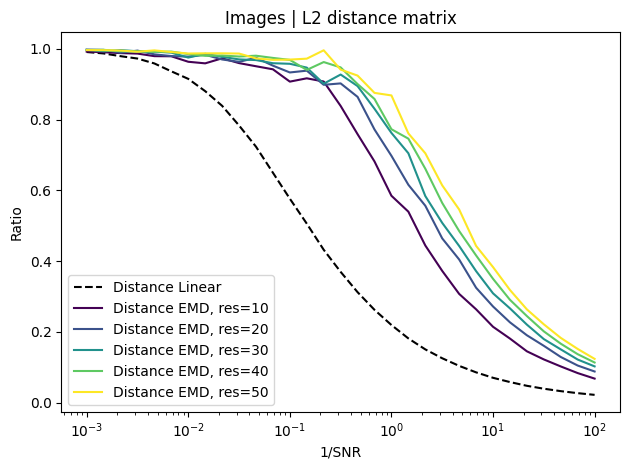

In [65]:
subset = df_im_l2[df_im_l2['Im_Size'] == im_size_values[1]]
plt.plot(1/subset['SNR'], subset['Ratios_Linear'], label='Distance Linear', color='black', linestyle='--')

colors = plt.cm.viridis(np.linspace(0, 1, len(im_size_values)))  # Generate colors for each 'res' value

for i, res_option in enumerate(im_size_values):
    # Filter the dataframe based on current 'res' option
    filtered_df = df_im_l2[df_im_l2['Im_Size'] == res_option]
    plt.plot(1/filtered_df['SNR'], filtered_df['Ratios_EMD'], label=f'Distance EMD, res={res_option}', color=colors[i])

plt.xscale('log')
plt.title('Images | L2 distance matrix')
plt.xlabel('1/SNR')
plt.ylabel('Ratio')
plt.legend()

plt.tight_layout()
plt.savefig('images/comparison/images_l2')